In [1]:
import bayes3d as b
import bayes3d.genjax
import joblib
from tqdm import tqdm
import os
import jax.numpy as jnp
import jax
import numpy as np
import genjax
from dataclasses import dataclass
from genjax.generative_functions.distributions import ExactDensity

In [2]:
def score_images(rendered, observed):
    return -jnp.linalg.norm(observed - rendered, axis=-1).mean()

def score_images_1(rendered, observed):
    mask = observed[...,2] < intrinsics.far
    return (jnp.linalg.norm(observed - rendered, axis=-1)* (1.0 * mask)).sum() / mask.sum()

def score_images_2(rendered, observed):
    return -jnp.linalg.norm(observed - rendered, axis=-1).mean()

def score_images_3(rendered, observed):
    distances = jnp.linalg.norm(observed - rendered, axis=-1)
    probabilities_per_pixel = jax.scipy.stats.norm.logpdf(
        distances,
        loc=0.0, 
        scale=0.02
    )
    image_probability = probabilities_per_pixel.mean()
    return image_probability

def score_images_4(rendered, observed):
    distances = jnp.linalg.norm(observed - rendered, axis=-1)
    width = 0.02
    probabilities_per_pixel = (distances < width/2) / width
    return probabilities_per_pixel.mean()

@dataclass
class DebugLikelihood(ExactDensity):
    def sample(self, key, img, variance, outlier_prob, outlier_volume, focal_length):
        return img

    def logpdf(self, image, s, variance, outlier_prob, outlier_volume, focal_length):
        return score_images_4(
            image, s)

@genjax.gen
def model_debug(array, possible_object_indices, pose_bounds, contact_bounds, all_box_dims, outlier_volume, focal_length):
    indices = jnp.array([], dtype=jnp.int32)
    root_poses = jnp.zeros((0,4,4))
    contact_params = jnp.zeros((0,3))
    faces_parents = jnp.array([], dtype=jnp.int32)
    faces_child = jnp.array([], dtype=jnp.int32)
    parents = jnp.array([], dtype=jnp.int32)
    for i in range(array.shape[0]):
        parent_obj = b.uniform_discrete(jnp.arange(-1,array.shape[0] - 1)) @ f"parent_{i}"
        parent_face = b.uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
        child_face = b.uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"
        index = b.uniform_discrete(possible_object_indices) @ f"id_{i}"

        pose = b.uniform_pose(
            pose_bounds[0], 
            pose_bounds[1], 
        ) @ f"root_pose_{i}"

        params = b.contact_params_uniform(
            contact_bounds[0], 
            contact_bounds[1]
        ) @ f"contact_params_{i}"


        indices = jnp.concatenate([indices, jnp.array([index])])
        root_poses = jnp.concatenate([root_poses, pose.reshape(1,4,4)])
        contact_params = jnp.concatenate([contact_params, params.reshape(1,-1)])
        parents = jnp.concatenate([parents, jnp.array([parent_obj])])
        faces_parents = jnp.concatenate([faces_parents, jnp.array([parent_face])])
        faces_child = jnp.concatenate([faces_child, jnp.array([child_face])])
    
    box_dims = all_box_dims[indices]
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)

    camera_pose = b.uniform_pose(
        pose_bounds[0], 
        pose_bounds[1], 
    ) @ f"camera_pose"

    rendered = b.RENDERER.render(
        jnp.linalg.inv(camera_pose) @ poses , indices
    )[...,:3]

    variance = genjax.distributions.tfp_uniform(0.00000000001, 10000.0) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(-0.01, 10000.0) @ "outlier_prob"
    image = DebugLikelihood()(rendered, variance, outlier_prob, outlier_volume, focal_length) @ "image"
    return rendered, indices, poses, parents, contact_params, faces_parents, faces_child, root_poses

In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [4]:
intrinsics = b.Intrinsics(
    height=50,
    width=50,
    fx=250.0, fy=250.0,
    cx=25.0, cy=25.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)


In [5]:
importance_jit = jax.jit(model_debug.importance)

contact_enumerators = [b.make_enumerator([f"contact_params_{i}", "variance", "outlier_prob"]) for i in range(5)]
add_object_jit = jax.jit(b.add_object)

def c2f_contact_update(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number].enumerate_choices_get_scores(trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number].update_choices(
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update, static_argnames=("number",))

In [6]:
OUTLIER_VOLUME = 1000.0
VARIANCE_GRID = jnp.array([0.0001, 0.001, 0.01])
OUTLIER_GRID = jnp.array([0.00001, 0.0001, 0.001])

grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), (0.02, jnp.pi, (5,5,51)), (0.01, jnp.pi/5, (11,11,11)), (0.01, 0.0, (21,21,1)),(0.05, 0.0, (21,21,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]


In [7]:
V_VARIANT = 0
O_VARIANT = 0
HIERARCHICAL_BAYES = True

if HIERARCHICAL_BAYES:
    V_GRID = VARIANCE_GRID
    O_GRID = OUTLIER_GRID
else:
    V_GRID, O_GRID = jnp.array([VARIANCE_GRID[V_VARIANT]]), jnp.array([OUTLIER_GRID[O_VARIANT]])

print(V_GRID, O_GRID)

[1.e-04 1.e-03 1.e-02] [1.e-05 1.e-04 1.e-03]


In [12]:
NUM_TESTS = 10
rand_int = np.random.randint(999999)

gt_traces = []
traces = []
keys = [jax.random.PRNGKey(x*rand_int) for x in range(NUM_TESTS)]
num_objects = 3

for key in keys:
    key = jax.random.split(key, 1)[0]
    table_pose = b.t3d.inverse_pose(
        b.t3d.transform_from_pos_target_up(
            jnp.array([0.0, 2.0, 1.20]),
            jnp.array([0.0, 0.0, 0.0]),
            jnp.array([0.0, 0.0, 1.0]),
        )
    )

    weight, gt_trace = importance_jit(key, genjax.choice_map({
        "parent_0": -1,
        "parent_1": 0,
        "parent_2": 0,
        "parent_3": 0,
        "id_0": jnp.int32(21),
        "camera_pose": jnp.eye(4),
        "root_pose_0": table_pose,
        "face_parent_1": 2,
        "face_parent_2": 2,
        "face_parent_3": 2,
        "face_child_1": 3,
        "face_child_2": 3,
        "face_child_3": 3,
        "variance": 0.0001,
        "outlier_prob": 0.0001,
    }), (
        jnp.arange(4),
        jnp.arange(22),
        jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
        jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
        b.RENDERER.model_box_dims, OUTLIER_VOLUME, 1.0)
    )
    print(gt_trace.get_score())

    _,trace = importance_jit(key, gt_trace.get_choices(), (jnp.arange(1), jnp.arange(22), *gt_trace.get_args()[2:]))
    b.viz_trace_rendered_observed(trace)

    all_all_paths = []
    for _ in range(3):
        all_paths = []
        for obj_id in tqdm(range(len(b.RENDERER.meshes)-1)):
            path = []
            trace_ = add_object_jit(trace, key, obj_id, 0, 2,3)
            number = b.get_contact_params(trace_).shape[0] - 1
            path.append(trace_)
            for c2f_iter in range(len(contact_param_gridding_schedule)):
                trace_ = c2f_contact_update_jit(trace_, key, number,
                    contact_param_gridding_schedule[c2f_iter], V_GRID, O_GRID)
                path.append(trace_)
            # for c2f_iter in range(len(contact_param_gridding_schedule)):
            #     trace_ = c2f_contact_update_jit(trace_, key, number,
            #         contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
            all_paths.append(
                path
            )
        all_all_paths.append(all_paths)
        
        scores = jnp.array([t[-1].get_score() for t in all_paths])
        print(scores)
        normalized_scores = b.utils.normalize_log_scores(scores)
        trace = all_paths[jnp.argmax(scores)][-1]
        b.viz_trace_meshcat(trace)

    gt_traces.append(gt_trace)
    traces.append(trace)

-33.584625


100%|██████████| 21/21 [00:02<00:00,  7.86it/s]


[  754.4335   3191.0771   1718.9817   -249.37378  1344.9778  -1595.8901
 -1470.8013  -1631.0953   -515.15906 -1673.94     4382.067    2804.1074
 -1383.2765   -545.5891  -1442.6924   3214.578   -1907.1467  -1926.3646
 -1690.5892  -1667.6744  -1226.0522 ]


100%|██████████| 21/21 [00:03<00:00,  6.38it/s]


[7335.366  7817.1655 7752.858  6525.0938 7644.873  5463.297  5588.386
 5428.0923 6263.9233 5385.2476 7675.637  7790.1143 5380.2925 6261.1987
 5213.276  7919.942  5152.0405 5132.8228 5357.0894 5225.873  5773.686 ]


100%|██████████| 21/21 [00:04<00:00,  4.90it/s]


[7905.641  7904.328  7910.848  7904.2944 7905.0923 7904.2944 7904.2944
 7904.2944 7904.2944 7904.2944 7805.9634 7904.8877 7887.245  7904.2944
 7870.1963 7904.2944 7904.2944 7904.2944 7904.2944 7853.147  7905.08  ]
-33.584625


100%|██████████| 21/21 [00:02<00:00,  7.95it/s]


[2547.819    4916.9194   3747.2554   1433.1956   3243.8777    217.44794
  783.5505    323.10785  1472.1769    622.6177   4151.843    3915.3618
  945.1393   1386.8018   1510.502    4316.8276    137.49046    61.974464
  656.881     807.33813   717.6783  ]


100%|██████████| 21/21 [00:03<00:00,  6.47it/s]


[6044.6167 5518.716  6019.4614 6754.922  6194.4175 6157.7197 6723.8228
 6263.3794 7366.486  6562.889  4867.513  5678.967  6885.4116 7356.103
 6690.7925 4902.29   6018.2397 6002.246  6553.0874 6413.8535 6657.9497]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


[7351.545  7351.5874 7353.8335 7350.8384 7353.0176 7466.9443 7494.965
 7451.9927 7527.628  7474.034  7316.7397 7351.8716 7519.5757 7631.458
 7301.1685 7351.516  7404.7373 7412.516  7464.0835 7442.358  7547.0024]
-33.584625


100%|██████████| 21/21 [00:02<00:00,  8.02it/s]


[2733.999   2354.353   3202.1077  3880.0374  3239.171   4808.69
 5149.6914  4900.0605  4045.702   4709.902    697.96655 2765.6719
 5608.832   4790.5493  4516.7896  1884.8796  4849.738   4313.0127
 5193.7666  5025.9     4592.5723 ]


100%|██████████| 21/21 [00:03<00:00,  6.30it/s]


[5133.766  4421.654  5838.4497 6508.389  5947.629  7382.7627 7549.4023
 7524.8237 6605.984  7327.657  3250.1738 5243.4565 6633.5737 6938.6587
 7266.0376 4448.7017 7492.419  6955.694  7836.448  7902.239  7215.895 ]


100%|██████████| 21/21 [00:04<00:00,  5.22it/s]


[5999.781  5857.741  7209.1665 7594.589  7124.2397 7879.4243 7811.0024
 7883.7036 7708.361  7873.2163 5226.9224 6424.413  7887.8022 7654.0894
 7558.84   5329.217  7966.279  7966.34   7990.2017 7853.6655 7895.427 ]
-33.584625


100%|██████████| 21/21 [00:03<00:00,  6.98it/s]


[3290.623  2081.9712 3694.6067 2607.1797 3593.9282 1317.693  1718.536
 1450.2369 2244.2935 2175.4407 1394.7399 2855.7114 1284.7195 2263.821
 2138.7097 2501.0183 1932.4575 1603.7308 2028.5544 1985.8898 1676.073 ]


100%|██████████| 21/21 [00:03<00:00,  6.47it/s]


[6816.1226 5606.4897 6248.8276 6131.698  6515.54   4842.2114 4943.1655
 4791.2607 5705.2617 4757.4146 4919.2583 5888.543  4950.14   5679.7407
 5034.9214 5341.8647 4728.631  4671.6255 4722.7183 4777.112  5160.9233]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


[6783.361  6024.538  6802.1133 6800.475  6765.862  7911.0396 7637.339
 7965.3096 7151.992  7803.0513 5503.8667 6203.757  6705.793  7097.979
 7463.0347 5726.378  7849.808  7792.8022 7773.5776 7560.3374 7816.718 ]
-33.584625


100%|██████████| 21/21 [00:02<00:00,  8.01it/s]


[4265.4634 5078.336  5095.9893 3803.769  5285.187  2757.8381 2831.4695
 2780.0808 3533.6643 2580.8018 4516.237  5642.533  2725.892  3454.4558
 2806.199  5015.8447 2761.7195 2442.9138 2598.6194 2809.2368 2954.3445]


100%|██████████| 21/21 [00:03<00:00,  6.43it/s]


[5454.3506 5180.776  5638.6157 6388.828  6089.941  7087.9897 7161.6206
 7110.2324 6477.2246 6910.9526 4622.8955 5629.1523 6079.9595 6547.1797
 6859.058  5336.1265 7091.8706 6773.0654 6928.7705 7109.492  7055.79  ]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


[6873.187  6699.5234 7157.3643 7145.973  7145.973  7654.     7644.8267
 7687.11   7149.1187 7765.622  6141.6436 7147.9014 7221.4224 7316.7837
 7418.099  6854.8745 7773.1753 7728.4185 7878.1646 7754.971  7568.0386]
-33.584625


100%|██████████| 21/21 [00:02<00:00,  7.10it/s]


[5633.898  4558.959  5792.121  6484.9556 5921.0415 7468.991  7699.9683
 7565.3027 6687.819  7488.8423 3498.2622 5365.6934 6846.7217 6937.547
 7524.18   4520.4854 7340.5    7072.951  7639.431  7677.1064 7387.6387]


100%|██████████| 21/21 [00:03<00:00,  6.53it/s]


[5814.773  5887.4175 6912.1484 7126.632  6798.5874 7704.3755 7713.4756
 7704.9233 7214.9946 7706.6514 4790.8765 6322.132  7186.8696 7223.442
 7635.0635 5361.6426 7779.4946 7956.046  7704.6143 7708.1226 7678.2314]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


[6144.0728 5934.9395 7125.421  7368.1147 6921.2915 7960.116  7969.214
 7960.6616 7456.477  7962.389  4883.8906 6397.956  7440.1333 7476.7056
 7888.3276 5494.693  7955.1235 7953.768  7960.3525 7963.861  7933.9683]
-33.584625


100%|██████████| 21/21 [00:02<00:00,  7.98it/s]


[2761.1516 3713.712  3186.2227 2519.9827 3193.356  1932.1154 2073.846
 1966.5403 2286.4785 2396.2998 3296.739  3161.4216 1853.4879 2297.3794
 3240.8818 3087.4978 1914.415  1637.9967 2397.868  2457.3684 1857.7957]


100%|██████████| 21/21 [00:03<00:00,  6.32it/s]


[3732.6675 3808.9307 4208.943  4205.6123 4286.4487 4964.264  5105.9946
 4998.689  4558.571  5428.4487 3743.843  4217.346  4885.636  4825.364
 6273.031  3802.5708 4946.5635 4670.1455 5430.0166 5489.5176 4996.865 ]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


[6291.6465 6367.909  6369.194  6327.533  6349.4688 6277.7715 6285.517
 6278.446  6318.068  6274.5864 6302.822  6375.3413 6270.1973 6304.941
 6314.419  6361.55   6272.449  6272.0044 6282.2114 6285.497  6294.707 ]
-33.584625


100%|██████████| 21/21 [00:02<00:00,  7.85it/s]


[6920.045  5072.1943 6296.68   6017.6733 6578.634  4512.6274 4638.1846
 4447.1025 5483.485  4404.463  3342.0894 5814.704  4288.4316 5464.581
 4336.7607 5158.573  4146.34   4205.2314 4371.6035 4224.63   4872.2544]


100%|██████████| 21/21 [00:03<00:00,  5.86it/s]


[6907.092  5375.944  6676.888  6904.737  6782.568  7827.8057 7639.1426
 7866.2207 7174.4297 7750.574  4245.0674 6088.1753 6444.409  7150.6514
 6960.571  5446.9995 7799.743  7861.1665 7684.9097 7277.857  7739.1714]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


[7852.9287 6321.7803 7622.7246 7850.573  7728.406  7850.573  7850.573
 7850.573  7850.573  7850.573  5190.9043 7034.0127 7390.2466 7850.573
 7339.098  6392.836  7850.573  7956.0796 7850.573  7628.9346 7850.573 ]
-33.584625


100%|██████████| 21/21 [00:02<00:00,  7.84it/s]


[4632.8315 4817.458  5305.497  5344.061  5075.711  6454.7354 6682.7993
 6476.399  5834.4272 6395.4097 4299.3833 5099.428  7076.7    6441.7266
 6120.3193 4603.2124 6302.3945 5877.1006 6547.2764 6401.8125 6176.489 ]


100%|██████████| 21/21 [00:03<00:00,  6.14it/s]


[6074.4575 5799.7056 6518.3745 6898.0303 6659.847  7694.305  7622.7026
 7795.372  6902.629  7728.899  4624.0005 6346.794  6941.2065 7084.8804
 7394.3306 5577.4653 7759.995  7740.586  8015.918  7578.148  7594.28  ]


100%|██████████| 21/21 [00:03<00:00,  5.25it/s]


[6248.2793 6736.109  7454.779  7765.385  7346.1147 7961.0947 7874.2153
 7967.682  7839.0327 7994.7173 5752.2866 7283.1978 8000.127  7759.449
 7582.107  6409.254  7976.646  8000.3564 8000.2705 7680.293  7968.7896]
-33.584625


100%|██████████| 21/21 [00:02<00:00,  7.97it/s]


[3326.2915 5894.234  4173.477  2359.155  3898.9646 1276.1691 1457.132
 1307.221  2232.3318 1502.6212 6366.2383 5332.0127 1514.9847 2189.899
 1796.8901 5700.8203 1099.2697 1036.7079 1487.4349 1609.4261 1643.975 ]


100%|██████████| 21/21 [00:03<00:00,  6.35it/s]


[6810.6777 6588.999  6882.021  6916.233  6890.215  7427.3003 7525.9565
 7462.0513 7113.0713 7535.4424 6359.5073 6645.9414 7697.692  7338.778
 7448.1562 6527.8545 7368.8887 7314.874  7550.1455 7536.806  7372.4565]


100%|██████████| 21/21 [00:04<00:00,  4.82it/s]


[7682.0444 7760.6333 7826.6733 7682.0444 7826.2817 7682.0444 7682.0444
 7682.0444 7682.0444 7903.185  7690.6206 7801.317  7682.0444 7682.0444
 7681.452  7682.0444 7856.538  7891.1855 7923.235  7682.0444 7682.0444]


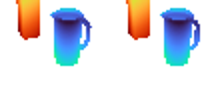

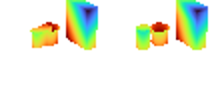

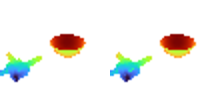

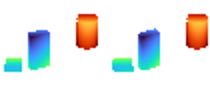

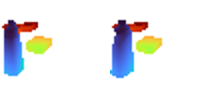

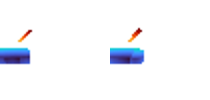

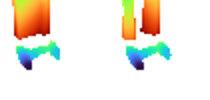

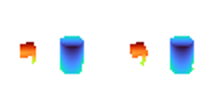

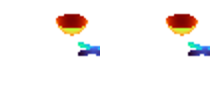

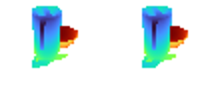

In [14]:
for i in range(len(traces)):
    display(b.viz_trace_rendered_observed(traces[i]))